
**Week4 Excercises**

Train a simple (single layer, single fully connected layer, etc.) neural network through JAX vectorization (maybe you can try vectorization techniques in PyTorch and Tensorflow respectively). Compare their performance with each and with the results derived in Week 3’s exercise.


Optional: For those who interested in Convolutional neural network, you can refer to this:
https://jax.readthedocs.io/en/latest/notebooks/convolutions.html 
and implement a CNN to predict the label of some famous datasets (I previously used Faces94 dataset as a Facial Recognition toy dataset, just for your reference. You can search for any datasets to use.)

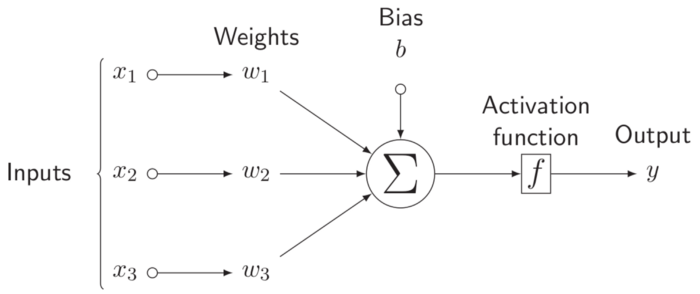

In [1]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np

import matplotlib.pyplot as plt
import timeit

# Create sample data

In [2]:
X, y = make_moons(n_samples=200, noise=0.1, random_state=0)
# X = np.hstack((X, np.ones_like(y).reshape(-1, 1)))

In [3]:
X[0:2]

array([[ 0.79235735,  0.50264857],
       [ 1.63158315, -0.4638967 ]])

In [4]:
X.shape[1]

2

# JAX model

Loss function (cross entropy):

\begin{align}
L=-\frac{1}{n}\sum_{i=1}^{n}(y_ilog(\bar{y_i}) + (1-y_i)log(1-\bar{y_i}))
\end{align}

In [5]:
import jax.numpy as jnp
from jax import grad, random, value_and_grad, vmap, jit
from jax.nn import sigmoid
import numpy as np


#Use jax vectorization
def linear_reg(X, W):
  return jnp.dot(X, W)

# vec_linear_reg = jit(vmap(vmap(linear_reg, (0, None)), (None, 0)))
vec_linear_reg = jit(vmap(linear_reg, (0, None)))



class JaxPerceptron:
  def __init__(self, X, y):
    key = random.PRNGKey(0)
    key, W_key, b_key = random.split(key, 3)
    self._X = jnp.asarray(X)
    self._y = jnp.asarray(y)
    self._W = random.normal(W_key, (X.shape[1],))
    self._b = random.normal(b_key, ())
    self._losses = []

  def predict_proba(self, X=None, W=None, b=None):
    if X is None:
      X = self._X
    if W is None:
      W = self._W
    if b is None:
      b = self._b

    return sigmoid(vec_linear_reg(X, W) + b)

  def loss(self, W=None, b=None):
    preds = self.predict_proba(W=W, b=b)
    label_probs = preds * self._y + (1 - preds) * (1 - self._y)
    return -jnp.sum(jnp.log(label_probs))

  def fit(self, n_iters=100, lr=0.1):
    self._losses = []
    loss_grad = value_and_grad(self.loss, (0, 1))

    for i in range(n_iters):
      tmp_loss, (W_grad, b_grad) = loss_grad(self._W, self._b)
      self._W = self._W - lr * W_grad
      self._b = self._b - lr * b_grad

      # tmp_loss = self.loss()
      self._losses.append(np.array(tmp_loss, ndmin=1)[0])
      if tmp_loss == 0:
        print("Loss is minimized at 0.")
        break

  def get_weights(self):
    return self._W, self._b
  
  def get_model_losses(self):
    return self._losses

In [6]:
jax_model = JaxPerceptron(X, y)
jax_model.get_weights()

(DeviceArray([ 1.2636864, -0.0423024], dtype=float32),
 DeviceArray(0.8535516, dtype=float32))

In [7]:
%%timeit

n_iters = 200
jax_model.fit(n_iters=n_iters, lr=0.01)
jax_model.get_weights()

2.08 s ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
jax_model.loss()

DeviceArray(52.104042, dtype=float32)